# 模拟投资策略

## 1. 数据预处理

In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model

# 全局变量定义
model_path = '../models/lstm_finetuning_model.h5'
cols = [0,1,2,3,4,6,7,9,14]
feanum=6 # 一共有多少特征
window=10 # 时间窗设置

In [2]:
# 读取测试集数据
df = pd.read_csv("../data/test.csv", usecols=cols)
stocks_code = df["kdcode"].unique()
stock_num = len(stocks_code)

# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code):
    stock_i_data = df[df['kdcode'].isin([stock_i])]
    exec("stockDf%s = stock_i_data" % i)
    exec("stockDf%s.set_index(['dt'], inplace = True)" % i)
    exec("stockDf%s.index = pd.to_datetime(stockDf%s.index)" % (i, i))

In [3]:
stockDf0

,kdcode,price_mean1,price_mean5,price_mean10,pct_mean3,pct_mean5,close_mean5,label
dt,,,,,,,,
2020-01-02,000001.SZ,0.007344,0.007478,0.007507,0.194480,0.198148,0.120051,1.0
2020-01-03,000001.SZ,0.007521,0.007545,0.007550,0.208026,0.201087,0.121080,1.0
2020-01-06,000001.SZ,0.007516,0.007584,0.007582,0.208543,0.195127,0.121717,0.0
2020-01-07,000001.SZ,0.007502,0.007650,0.007616,0.195698,0.198194,0.122557,1.0
2020-01-08,000001.SZ,0.007338,0.007677,0.007628,0.166769,0.190307,0.122861,0.0
...,...,...,...,...,...,...,...,...
2020-12-25,000001.SZ,0.007945,0.008300,0.008513,0.190352,0.178923,0.133137,0.0
2020-12-28,000001.SZ,0.008214,0.008337,0.008498,0.214577,0.197138,0.133976,1.0
2020-12-29,000001.SZ,0.008499,0.008442,0.008535,0.216137,0.211104,0.135848,1.0


In [4]:
# 读取并处理出各股票的开盘价、收盘价未归一化的数据
# 读取数据
df2 = pd.read_csv("strategyTestData.csv")
stocks_code2 = df2["kdcode"].unique()
stock_num2 = len(stocks_code2)

# 根据股票代码划分数据
for i, stock_i in enumerate(stocks_code2):
    stock_i_data = df2[df2['kdcode'].isin([stock_i])]
    exec("PriceMsgDf%s = stock_i_data" % i)
    exec("PriceMsgDf%s.set_index(['dt'], inplace = True)" % i)
    exec("PriceMsgDf%s.index = pd.to_datetime(stockDf%s.index)" % (i, i))

In [5]:
PriceMsgDf81

,kdcode,adj_close,adj_open
dt,,,
2020-01-02,603833.SH,118.470896,118.795807
2020-01-03,603833.SH,118.328747,118.795807
2020-01-06,603833.SH,115.749761,115.749761
2020-01-07,603833.SH,118.389668,117.272784
2020-01-08,603833.SH,118.186598,117.029100
...,...,...,...
2020-12-25,603833.SH,171.287863,176.289910
2020-12-28,603833.SH,180.231351,170.671565
2020-12-29,603833.SH,179.686715,178.726437


## 2. 模拟投资策略

In [6]:
model = load_model(model_path) # 加载模型

In [7]:
now_money = 1000000 # 初始总钱
position_num = 5 # 最多持有股票的数量
threshold = 0.55 # 表示预测为涨的阈值

# 判断index股票在day日是否可以交易
# param: index 第几只股票
#        day 哪一天
#        pList 所有股票预测出的概率
def canBuyOrSell(stock_index, day, pList):
    # 判断是否停牌
    day = pd.to_datetime(day)
    res = nowData[nowData.index.isin([day])]
    if len(res) == 0:
        return False
    # 判断pList中index股票p是否等于nan
    for [p,ind] in pList:
        if ind == stock_index and np.isnan(p):
            return False
    return True

# 策略
PriorList = [] # 每天最优持有的股票
tot = len(stockDf0.index[:-window + 1]) # 总天数
allPSetList = [] # 每天股票与概率的字典的列表
for (t,st_date) in enumerate(stockDf0.index[:-window + 1]):
    date_period = pd.date_range(start = st_date, periods = window + 1, freq = "B")
    today = date_period[-1]
    pList = [] # 当天所有股票的概率 [[p,index],...[]]
    pDict = dict()
    for stock_index in range(stock_num):
        # 1. 处理为LSTM输入的数据
        exec("inputData = stockDf%s[stockDf%s.index.isin(date_period[:-1])]" % (stock_index, stock_index))
        inputData = inputData.iloc[:,[1,2,3,4,5,6]]
        inputData = inputData.values
        inputData = inputData.reshape((1,inputData.shape[0],feanum))
        # 2. 模型预测结果
        if inputData.shape[1] == 0: # Todo 包含停牌数据预测的处理
            p = np.nan
        else:
            p = model.predict(inputData)[:,0][0]
        pList.append([p,stock_index])
        pDict[stock_index] = p
    pList.sort(reverse = True) # 从高到低排序
    allPSetList.append(pDict)
    
    # 将canBuyOrSell并且p大于threshold的股票加入到PriList中
    tmpList = []
    for i in range(stock_num):
        exec("nowData = stockDf%s.copy()" % i)
        if canBuyOrSell(pList[i][1], today, pList) and pList[i][0] > threshold:
            tmpList.append(pList[i][1])
    tmpList = tmpList[:min(5, len(tmpList))]
    PriorList.append(tmpList)
    print("tot:", tot, t + 1, tmpList)

tot: 234 1 [39]
tot: 234 2 [43, 45]
tot: 234 3 [77]
tot: 234 4 [22]
tot: 234 5 [22, 74, 36, 3, 0]
tot: 234 6 [74, 22, 3]
tot: 234 7 []
tot: 234 8 []
tot: 234 9 []
tot: 234 10 []
tot: 234 11 []
tot: 234 12 []
tot: 234 13 [3, 56, 22, 63, 17]
tot: 234 14 [3, 56, 17, 37, 0]
tot: 234 15 [3, 74, 54, 52, 37]
tot: 234 16 [3, 74, 12, 56]
tot: 234 17 [16, 37, 68, 74, 76]
tot: 234 18 [74, 35, 54, 37]
tot: 234 19 []
tot: 234 20 [39]
tot: 234 21 [80]
tot: 234 22 [80]
tot: 234 23 [80, 39]
tot: 234 24 [39, 80]
tot: 234 25 [39, 15, 8]
tot: 234 26 [80, 39, 50, 9]
tot: 234 27 [80, 50, 74, 14, 39]
tot: 234 28 [80, 39, 8, 45, 13]
tot: 234 29 [50, 15]
tot: 234 30 [14, 51, 13, 75, 74]
tot: 234 31 [80, 48, 75]
tot: 234 32 [80, 50, 8, 14, 48]
tot: 234 33 [50, 14, 20, 51, 80]
tot: 234 34 [48]
tot: 234 35 [48]
tot: 234 36 [80, 68, 14, 1, 10]
tot: 234 37 [40, 80, 45, 14, 68]
tot: 234 38 [14, 80, 40, 21, 31]
tot: 234 39 [40, 77, 14, 3, 39]
tot: 234 40 [45, 0, 39, 3, 77]
tot: 234 41 [74, 3, 0, 39, 36]
tot: 234 42 

<ipython-input-7-2b263b9758fe>:43: RuntimeWarning: invalid value encountered in greater
  pList.sort(reverse = True) # 从高到低排序
<ipython-input-7-2b263b9758fe>:43: RuntimeWarning: invalid value encountered in less
  pList.sort(reverse = True) # 从高到低排序


tot: 234 45 [4, 75, 77]
tot: 234 46 [36, 63, 0, 3, 4]
tot: 234 47 [36, 63, 51, 37, 7]
tot: 234 48 [74, 68, 80, 50, 7]
tot: 234 49 [50, 77, 51, 48, 22]
tot: 234 50 [22, 5, 51, 75]
tot: 234 51 [63, 36, 16]
tot: 234 52 []
tot: 234 53 [50, 14, 15, 51, 43]
tot: 234 54 [50, 51, 15, 14, 36]
tot: 234 55 [15, 63, 36, 42]
tot: 234 56 [43]
tot: 234 57 [36]
tot: 234 58 [9, 36, 44]
tot: 234 59 []
tot: 234 60 [7, 8, 74]
tot: 234 61 [50, 14, 76, 7]
tot: 234 62 [7]
tot: 234 63 [7, 39, 51]
tot: 234 64 []
tot: 234 65 [14]
tot: 234 66 [14, 39, 77, 50, 51]
tot: 234 67 [75, 77, 39, 7, 10]
tot: 234 68 [39]
tot: 234 69 [39, 56, 38, 77]
tot: 234 70 []
tot: 234 71 []
tot: 234 72 []
tot: 234 73 [39, 56, 77, 3]
tot: 234 74 []
tot: 234 75 [39]
tot: 234 76 [39, 38]
tot: 234 77 [39]
tot: 234 78 [39, 74, 56]
tot: 234 79 [74, 39, 56]
tot: 234 80 []
tot: 234 81 [74, 18, 42]
tot: 234 82 [74, 14, 31, 23, 56]
tot: 234 83 [80, 0, 56, 23, 39]
tot: 234 84 [39, 3]
tot: 234 85 []
tot: 234 86 [19, 15, 31, 48, 80]
tot: 234 87 [

In [50]:
# 回测
init_money = 1000000 # 初始资金
now_money = 1000000
nowStock = [] # 当前持有的股票
buyOrSellNum = 200 # 买或卖buyOrSellNum股
moneyList = []
openPriceCache = dict()
for (t,st_date) in enumerate(stockDf0.index[:-window]):
    date_period = pd.date_range(start = st_date, periods = window + 1, freq = "B")
    today = date_period[-1]
    pNowStock = [] # 当前持有股票的涨跌概率
    pSet = allPSetList[t] # 当天所有股票涨跌概率
    # 求当前持有股票的涨跌概率
    for stock in nowStock:
        p = pSet[stock]
        pNowStock.append([p, stock])
    # 卖掉所有持有的可以操作的股票
    print(t, "卖前", now_money, nowStock)
    for [p, stock_idx] in pNowStock:
        if canBuyOrSell(stock_idx, today, pNowStock):
            exec("res = PriceMsgDf%s[PriceMsgDf%s.index.isin([today])]" % (stock_idx, stock_idx))
            if len(res) == 0:
                continue
            open_price = res['adj_open'].values[0]
            nowStock.remove(stock_idx)
            now_money += open_price * buyOrSellNum
            openPriceCache[stock_idx] = open_price
    print(t, "卖后", now_money, nowStock)
    
    # 尽可能多的买下所有当天最优的持有股票
    DestList = PriorList[t]
    for stock_idx in DestList:
        exec("res = PriceMsgDf%s[PriceMsgDf%s.index.isin([today])]" % (stock_idx, stock_idx))
        if len(res) == 0:
            continue                                  # 这里不能continue
        open_price = res['adj_open'].values[0]
        if now_money > (open_price * buyOrSellNum):
            now_money -= open_price * buyOrSellNum
            nowStock.append(stock_idx)
            openPriceCache[stock_idx] = open_price
    print(t, "买后", now_money, nowStock)
    
    # 计算当前所有资金（持有资金 股票资金）
    tot_money = now_money
    for stock_idx in nowStock:
        exec("res = PriceMsgDf%s[PriceMsgDf%s.index.isin([today])]" % (stock_idx, stock_idx))
        if len(res) == 0:
            open_price = openPriceCache[stock_idx]
        else:
            open_price = res['adj_open'].values[0]
        tot_money += open_price * buyOrSellNum
    moneyList.append(tot_money)
    
print("maximum in total money", max(moneyList))
print("final total money:", moneyList[-1])

0 卖前 1000000 []
0 卖后 1000000 []
0 买后 222189.19455112005 [39]
1 卖前 222189.19455112005 [39]
1 卖后 989882.4244841201 []
1 买后 865589.3758835801 [43, 45]
2 卖前 865589.3758835801 [43, 45]
2 卖后 991052.4705691201 []
2 买后 988174.5714777801 [77]
3 卖前 988174.5714777801 [77]
3 卖后 991100.9608655202 []
3 买后 944135.7551402801 [22]
4 卖前 944135.7551402801 [22]
4 卖后 991034.0826800801 []
4 买后 10037.888103739999 [22, 74, 36, 3, 0]
5 卖前 10037.888103739999 [22, 74, 36, 3, 0]
5 卖后 999699.20728832 []
5 买后 386264.53828005993 [74, 22, 3]
6 卖前 386264.53828005993 [74, 22, 3]
6 卖后 386264.53828005993 [74, 22, 3]
6 买后 386264.53828005993 [74, 22, 3]
7 卖前 386264.53828005993 [74, 22, 3]
7 卖后 386264.53828005993 [74, 22, 3]
7 买后 386264.53828005993 [74, 22, 3]
8 卖前 386264.53828005993 [74, 22, 3]
8 卖后 386264.53828005993 [74, 22, 3]
8 买后 386264.53828005993 [74, 22, 3]
9 卖前 386264.53828005993 [74, 22, 3]
9 卖后 386264.53828005993 [74, 22, 3]
9 买后 386264.53828005993 [74, 22, 3]
10 卖前 386264.53828005993 [74, 22, 3]
10 卖后 386264.53

99 卖后 991476.8249227207 []
99 买后 897843.7724931206 [50]
100 卖前 897843.7724931206 [50]
100 卖后 990867.4992019206 []
100 买后 411110.61855692044 [3]
101 卖前 411110.61855692044 [3]
101 卖后 994365.4736773205 []
101 买后 139926.47321648046 [3, 0]
102 卖前 139926.47321648046 [3, 0]
102 卖后 1008181.7353566007 []
102 买后 975232.9657902007 [9]
103 卖前 975232.9657902007 [9]
103 卖后 1006216.9004742007 []
103 买后 975232.9657902007 [9]
104 卖前 975232.9657902007 [9]
104 卖后 1006431.0170960007 []
104 买后 1006431.0170960007 []
105 卖前 1006431.0170960007 []
105 卖后 1006431.0170960007 []
105 买后 1006431.0170960007 []
106 卖前 1006431.0170960007 []
106 卖后 1006431.0170960007 []
106 买后 1006431.0170960007 []
107 卖前 1006431.0170960007 []
107 卖后 1006431.0170960007 []
107 买后 975484.8676982007 [9]
108 卖前 975484.8676982007 [9]
108 卖后 1006657.7288132007 []
108 买后 391363.8688199007 [3, 15]
109 卖前 391363.8688199007 [3, 15]
109 卖后 1009654.1769403007 []
109 买后 23220.543647500686 [39]
110 卖前 23220.543647500686 [39]
110 卖后 994494.6990260609

187 卖前 168052.5431168391 [71, 39, 8]
187 卖后 1231561.6875423393 []
187 买后 59765.589142879224 [39, 50, 1, 71]
188 卖前 59765.589142879224 [39, 50, 1, 71]
188 卖后 1238955.8901037988 []
188 买后 64279.59581899912 [39, 50, 1]
189 卖前 64279.59581899912 [39, 50, 1]
189 卖后 1209743.1772664993 []
189 买后 147557.64948737918 [39, 1, 77, 71]
190 卖前 147557.64948737918 [39, 1, 77, 71]
190 卖后 1216668.7352702394 []
190 买后 470174.92497351946 [56, 38, 71, 15]
191 卖前 470174.92497351946 [56, 38, 71, 15]
191 卖后 1236326.4109292196 []
191 买后 778562.7704830796 [71, 7, 46]
192 卖前 778562.7704830796 [71, 7, 46]
192 卖后 1245107.3056215798 []
192 买后 1219825.1177815797 [7]
193 卖前 1219825.1177815797 [7]
193 卖后 1243551.4786775797 []
193 买后 484998.12289631966 [7, 56, 66, 70, 1]
194 卖前 484998.12289631966 [7, 56, 66, 70, 1]
194 卖后 1237198.1735300396 []
194 买后 111163.62009259964 [7, 38, 39, 70]
195 卖前 111163.62009259964 [7, 38, 39, 70]
195 卖后 1263244.2372876396 []
195 买后 296235.9147682797 [39, 70]
196 卖前 296235.9147682797 [39, 70

Text(0, 0.5, 'Profit Ratio(%)')

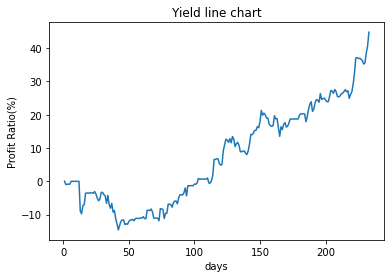

In [52]:
# 收益率变化曲线
import matplotlib.pyplot as plt

days = range(1, len(stockDf0.index[:-window]) + 1)
moneyList = np.array(moneyList)
profit_ratio = (moneyList - init_money) / init_money
profit_ratio *= 100
profit_ratio

plt.plot(days, profit_ratio, label = 'Profit Ratio')
plt.title('Yield line chart')
plt.xlabel('days')
plt.ylabel('Profit Ratio(%)')

## 单元测试

In [ ]:
# 单元测试1 测试canBuyOrSell函数

ppList = [[np.nan, 22], [0.59513134, 56], [0.5911934, 3], [0.56857383, 74], [0.5606358, 17], [0.5588775, 63], [0.558492, 19], [0.557015, 0], [0.5553074, 9], [0.55123156, 12], [0.54988277, 16], [0.5480421, 2], [0.54735094, 70], [0.5437275, 49], [0.54151696, 47], [0.54024804, 45], [0.54002637, 39], [0.53971076, 30], [0.5383594, 31], [0.5382879, 36], [0.5356826, 21], [0.5341861, 81], [0.53320944, 40], [0.53318095, 37], [0.53308034, 42], [0.52598095, 55], [0.52560496, 10], [0.52555954, 69], [0.5246366, 33], [0.5243099, 52], [0.5231771, 41], [0.5219507, 66], [0.5217557, 35], [0.5212795, 38], [0.5198239, 25], [0.5172703, 53], [0.514381, 32], [0.51411617, 61], [0.51250756, 6], [0.5116291, 24], [0.50913256, 11], [0.5075126, 54], [0.5067256, 71], [0.50646174, 48], [0.5046982, 7], [0.501216, 34], [0.5010961, 68], [0.5009133, 57], [0.49952868, 60], [0.49559373, 64], [0.4954788, 65], [0.49384275, 72], [0.4913066, 4], [0.4911093, 58], [0.48906785, 18], [0.48707077, 23], [0.48694274, 44], [0.48640633, 8], [0.48550946, 26], [0.4818525, 75], [0.48141715, 20], [0.47996283, 14], [0.47836575, 5], [0.47822124, 1], [0.47653505, 28], [0.4753328, 46], [0.47372493, 43], [0.47319898, 15], [0.47246543, 62], [0.4718764, 76], [0.47153977, 73], [0.47098902, 78], [0.4689083, 80], [0.46864882, 51], [0.46791682, 59], [0.46549064, 67], [0.4626018, 27], [0.46060893, 13], [0.46038687, 79], [0.4581696, 50], [0.4568532, 29], [0.45347258, 77]]

# 判断index股票在day日是否可以交易
# param: index 第几只股票
#        day 哪一天
#        pList 所有股票预测出的概率
def canBuyOrSell(stock_index, day, pList):
    # 判断是否停牌
    day = pd.to_datetime(day)
    res = nowData[nowData.index.isin([day])]
    if len(res) == 0:
        return False
    # 判断pList中index股票p是否等于nan
    for [p,ind] in pList:
        if ind == stock_index and np.isnan(p):
            return False
    return True

input_day = pd.to_datetime('2020-01-02')
exec("nowData = stockDf%s.copy()" % 21)
canBuyOrSell(21, input_day, ppList)